In [1]:
import copy
from itertools import compress

import pandas as pd
import numpy as np

import pint.toa as toa
import pint.models as models
import pint.residuals as r
import pint.fitter as fit
from pint.toa_select import TOASelect

import matplotlib.pyplot as plt

import astropy.units as u

In [29]:
t = toa.get_TOAs("./datafiles/PvT/B1112+50_test_t2.tim", usepickle=False)

INFO: Applying clock corrections (include_gps = True, include_bipm = True) [pint.toa]
INFO: Applying observatory clock corrections. [pint.observatory.topo_obs]
INFO: Applying GPS to UTC clock correction (~few nanoseconds) [pint.observatory.topo_obs]
INFO: Applying TT(TAI) to TT(BIPM2019) clock correction (~27 us) [pint.observatory.topo_obs]
INFO: Computing TDB columns. [pint.toa]
INFO: Using EPHEM = DE421 for TDB calculation. [pint.toa]
INFO: Computing PosVels of observatories and Earth, using DE421 [pint.toa]


In [30]:
m = models.get_model("./datafiles/1112.par")

In [39]:
def get_interval_toas(toas, start, stop):
    mask_toas = []
    copy_toas = copy.copy(toas)
    toas_table = toas.table
    for val in toas_table['mjd_float']:
        if start < val < stop:
            mask_toas.append(True)
        else:
            mask_toas.append(False)
    copy_toas.select(mask_toas)
    return copy_toas


def get_intervals_toas(toas, intervals):
    total_maks = []
    for start, stop in intervals:
        mask_toas = []
        copy_toas = copy.copy(t)
        toas_table = copy_toas.table
        for val in toas_table['mjd_float']:
            if start < val < stop:
                mask_toas.append(False)
            else:
                mask_toas.append(True)
        total_maks.append(mask_toas)

    primary_mask = np.full(copy_toas.ntoas, False)
    for item in total_maks:
        primary_mask = primary_mask ^ np.array(item)
    
    copy_toas.select(primary_mask)
    return copy_toas


def get_toas_by_residuals(toas, residuals, value_up, value_down, dimension):
    result = []
    for i, val in enumerate(residuals.to(dimension)):
        if val.value < value_down:
            result.append(toas.get_mjds()[i].value)
        elif val.value > value_up:
            result.append(toas.get_mjds()[i].value)
        else:
            continue
            
    return result


def exclude_toas(toas, list_mjd):
    mask_toas = []
    copy_toas = copy.copy(toas)
    toas_table = toas.table
    for val in toas_table['mjd_float']:
        if val in list_mjd:
            mask_toas.append(False)
        else:
            mask_toas.append(True)
    copy_toas.select(mask_toas)
    return copy_toas


def exclude_intervals_toas(toas, intervals):
    total_maks = []
    for start, stop in intervals:
        mask_toas = []
        copy_toas = copy.copy(t)
        toas_table = copy_toas.table
        for val in toas_table['mjd_float']:
            if start < val < stop:
                mask_toas.append(False)
            else:
                mask_toas.append(True)
        total_maks.append(mask_toas)

    primary_mask = np.full(copy_toas.ntoas, True)
    for item in total_maks:
        primary_mask = primary_mask ^ np.array(item)
    
    copy_toas.select(primary_mask)
    return copy_toas

In [43]:
f = fit.WLSFitter(t, m)
f.fit_toas()

130 ms ± 3.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


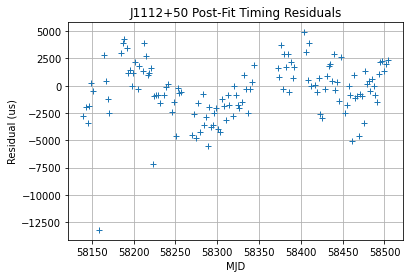

In [14]:
plt.plot(t.get_mjds(), f.resids.time_resids.to(u.us), '+')
plt.title("%s Post-Fit Timing Residuals" % m.PSR.value)
plt.xlabel("MJD")
plt.ylabel("Residual (us)")
plt.grid()

In [18]:
t_part = get_interval_toas(t, 58150, 58400)

In [19]:
f = fit.WLSFitter(t_part, m)
f.fit_toas()

55336.28060778563

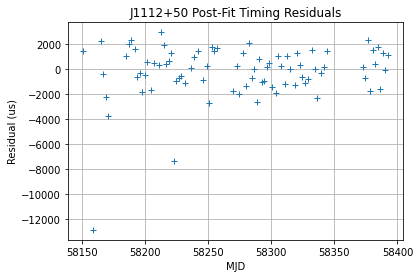

In [20]:
plt.plot(t_part.get_mjds(), f.resids.time_resids.to(u.us), '+')
plt.title("%s Post-Fit Timing Residuals" % m.PSR.value)
plt.xlabel("MJD")
plt.ylabel("Residual (us)")
plt.grid()

In [24]:
t_parts = get_intervals_toas(t, [(58150, 58200), (58400, 58450)])

In [25]:
f = fit.WLSFitter(t_parts, m)
f.fit_toas()

46479.1875963819

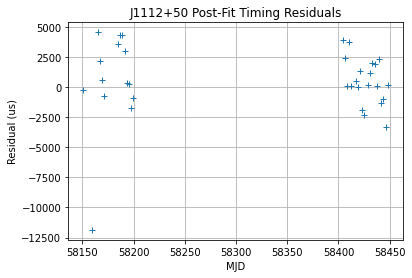

In [26]:
plt.plot(t_parts.get_mjds(), f.resids.time_resids.to(u.us), '+')
plt.title("%s Post-Fit Timing Residuals" % m.PSR.value)
plt.xlabel("MJD")
plt.ylabel("Residual (us)")
plt.grid()

In [33]:
list_trash = get_toas_by_residuals(t, f.resids.time_resids.to(u.us), 5000, -5500, u.us)

In [34]:
t_clear = exclude_toas(t, list_trash)

In [35]:
f = fit.WLSFitter(t_clear, m)
f.fit_toas()

159625.78267441224

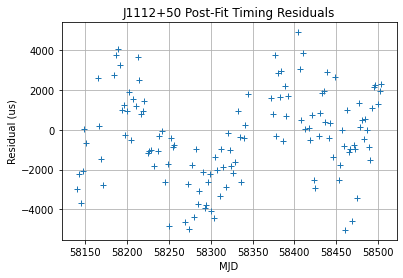

In [37]:
plt.plot(t_clear.get_mjds(), f.resids.time_resids.to(u.us), '+')
plt.title("%s Post-Fit Timing Residuals" % m.PSR.value)
plt.xlabel("MJD")
plt.ylabel("Residual (us)")
plt.grid()

In [40]:
t_trash_parts = exclude_intervals_toas(t, [(58150, 58200), (58400, 58450)])

In [41]:
f = fit.WLSFitter(t_trash_parts, m)
f.fit_toas()

122879.73965247812

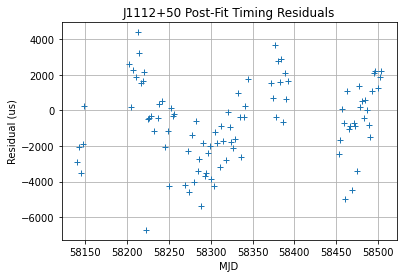

In [42]:
plt.plot(t_trash_parts.get_mjds(), f.resids.time_resids.to(u.us), '+')
plt.title("%s Post-Fit Timing Residuals" % m.PSR.value)
plt.xlabel("MJD")
plt.ylabel("Residual (us)")
plt.grid()